In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing

In [98]:
df = pd.read_csv("Churn_Modelling.csv")

In [99]:
df.drop(['RowNumber','CustomerId','Surname'], axis = 1, inplace = True)

In [100]:
data = df

In [101]:
le = preprocessing.LabelEncoder()

col_list = data.select_dtypes(include = "object").columns
for colsn in col_list:
    data[colsn] = le.fit_transform(data[colsn].astype(str))

In [102]:
def remove_outliers_iqr(data, column, threshold=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    num_rows_before = data.shape[0]
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    num_rows_after = data.shape[0]
    num_rows_removed = num_rows_before - num_rows_after
    print(f"Number of rows removed in '{column}': {num_rows_removed}")
    return data

numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

for column in numerical_columns:
    data = remove_outliers_iqr(data, column)

Number of rows removed in 'CreditScore': 15
Number of rows removed in 'Age': 359
Number of rows removed in 'Tenure': 0
Number of rows removed in 'Balance': 0
Number of rows removed in 'EstimatedSalary': 0


In [103]:
features = list(data.columns[:10])
print("features:", features, sep="\n")

features:
['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [104]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

y = data["Exited"]
X = data[features]

selector = SelectKBest(chi2, k=8)
selector.fit(X, y)

X_new = selector.transform(X)
print(data.columns[selector.get_support(indices=True)].tolist())
final_features = data.columns[selector.get_support(indices=True)].tolist()

['CreditScore', 'Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts', 'IsActiveMember', 'EstimatedSalary']


In [105]:
selector = SelectKBest(f_classif, k=8)
selector.fit(X, y)

X_new = selector.transform(X)
#print(data.columns[selector.get_support(indices=True)].tolist())
final_features = data.columns[selector.get_support(indices=True)].tolist()
final_feature = final_features.remove("Balance")
print(final_features)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'NumOfProducts', 'IsActiveMember']


In [106]:
# from yellowbrick.target import ClassBalance
# visualizer = ClassBalance(labels=["Yes", "No"])

# visualizer.fit(df["Exited"])
# visualizer.show()

In [107]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)

# counter = Counter(y)
# print(counter)

In [108]:
# visualizer = ClassBalance(labels=["Yes", "No"])
# visualizer.fit(y)
# visualizer.show()

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [110]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [111]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# scaler0=StandardScaler()
# scaler0.fit(X_train,y_train)
#
# X_train = pd.DataFrame(
#     scaler0.transform(X_train),
#     columns=X_train.columns
# )
#
# X_test = pd.DataFrame(
#     scaler0.transform(X_test),
#     columns=X_train.columns
# )

In [112]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.metrics import r2_score
from scipy.stats import uniform, randint

In [113]:
# Initialize an empty list to store model scores
model_scores = []

# Create a list of models to evaluate
models = [
    ('Random Forest', RandomForestClassifier(random_state=42),
     {'model__n_estimators': [50, 100, 200],
      'model__max_depth': [None, 10, 20]}),  # Add hyperparameters for Random Forest
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42),
     {'model__n_estimators': [50, 100, 200],
      'model__learning_rate': [0.05, 0.1, 0.5]}),  # Add hyperparameters for Gradient Boosting
    ('Support Vector Machine', SVC(random_state=42, class_weight='balanced'),
     {'model__C': [0.1, 1, 10],
      'model__gamma': ['scale', 'auto']}),  # Add hyperparameters for SVM
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced'),
     {'model__C': [0.1, 1, 10],
      'model__solver': ['liblinear', 'saga'],
      'model__penalty': ['l1', 'l2']}),  # Add hyperparameters for Logistic Regression
    ('K-Nearest Neighbors', KNeighborsClassifier(),
     {'model__n_neighbors': [3, 5, 7],
      'model__weights': ['uniform', 'distance']}),  # Add hyperparameters for KNN
    ('Decision Tree', DecisionTreeClassifier(random_state=42),
     {'model__max_depth': [None, 10, 20],
      'model__min_samples_split': [2, 5, 10]}),  # Add hyperparameters for Decision Tree
    ('Ada Boost', AdaBoostClassifier(random_state=42),
     {'model__n_estimators': [50, 100, 200],
      'model__learning_rate': [0.05, 0.1, 0.5]}),  # Add hyperparameters for Ada Boost
    ('XG Boost', XGBClassifier(random_state=42),
     {'model__n_estimators': [50, 100, 200],
      'model__learning_rate': [0.05, 0.1, 0.5]}),  # Add hyperparameters for XG Boost
    ('Naive Bayes', GaussianNB(), {})  # No hyperparameters for Naive Bayes
]

best_model = None
best_accuracy = 0.0

# Iterate over the models and evaluate their performance
for name, model, param_grid in models:
    # Create a pipeline for each model
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  # Feature Scaling
        ('model', model)
    ])

    # Hyperparameter tuning using GridSearchCV
    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=2)
        grid_search.fit(X_train, y_train)
        pipeline = grid_search.best_estimator_

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    # r2_score = r2_score(y_test,y_pred)
    # Append model name and accuracy to the list
    model_scores.append({'Model': name, 'Accuracy': accuracy})

    # Convert the list to a DataFrame
    scores_df = pd.DataFrame(model_scores)
    # Print the performance metrics
    print("Model:", name)
    print("Test Accuracy:", round(accuracy,3),"%")
    # print("R2 Score:", r2_score)
    print()

    # Check if the current model has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

# Retrieve the overall best model
print("Best Model:")
print("Test Accuracy:", best_accuracy)
print("Model Pipeline:", best_model, "with accuracy", round(best_accuracy,2), "%")

Model: Random Forest
Test Accuracy: 0.854 %

Model: Gradient Boosting
Test Accuracy: 0.85 %

Model: Support Vector Machine
Test Accuracy: 0.786 %

Model: Logistic Regression
Test Accuracy: 0.737 %

Model: K-Nearest Neighbors
Test Accuracy: 0.822 %

Model: Decision Tree
Test Accuracy: 0.832 %



C:\Users\kshit\OneDrive\Desktop\Datalore\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\kshit\OneDrive\Desktop\Datalore\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\kshit\OneDrive\Desktop\Datalore\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\kshit\OneDrive\Desktop\Datalore\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

Model: Ada Boost
Test Accuracy: 0.848 %

Model: XG Boost
Test Accuracy: 0.856 %

Model: Naive Bayes
Test Accuracy: 0.835 %

Best Model:
Test Accuracy: 0.8561786085150571
Model Pipeline: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                           

C:\Users\kshit\AppData\Local\Temp\ipykernel_13956\3914911918.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=scores_df, palette=colors)


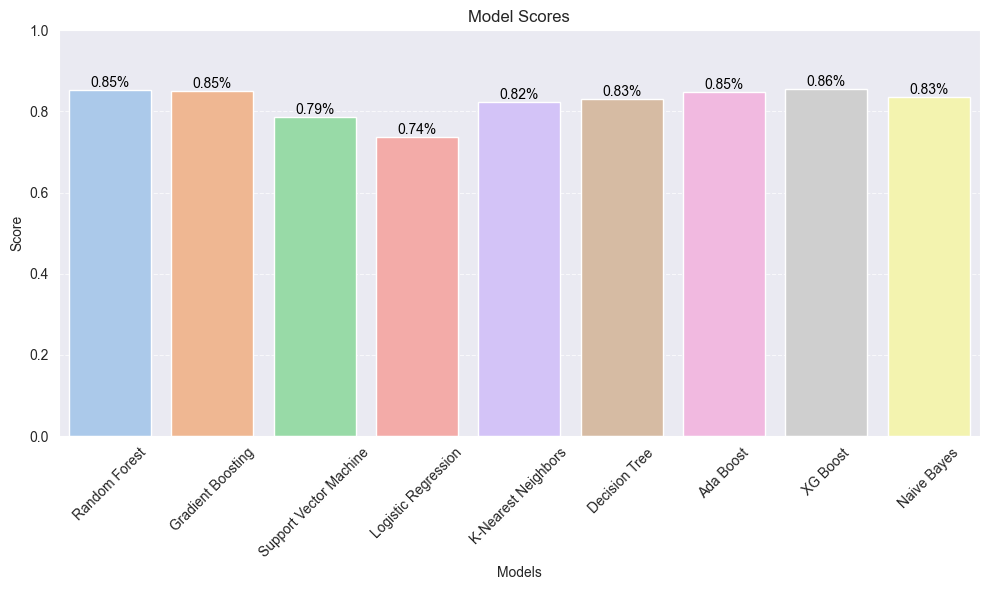

In [114]:
# Define a color palette for the bars
colors = sns.color_palette('pastel', n_colors=len(scores_df))

# Create a bar plot of models and their scores
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=scores_df, palette=colors)

# Add text on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Model Scores')
plt.xlabel('Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [115]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.stats import uniform, randint

# UpSampling
sm = SMOTEENN()
X_res, y_res = sm.fit_resample(X, y)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_res, y_res, test_size=0.2)

# Initialize an empty list to store model scores
model_scores = []

# Create a list of models to evaluate
models = [
    ('Random Forest', RandomForestClassifier(random_state=42),
        {'n_estimators': [50, 100, 200],
         'max_depth': [None, 10, 20]}),  # Add hyperparameters for Random Forest
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42),
        {'n_estimators': [50, 100, 200],
         'learning_rate': [0.05, 0.1, 0.5]}),  # Add hyperparameters for Gradient Boosting
    ('Support Vector Machine', SVC(random_state=42, class_weight='balanced'),
        {'C': [0.1, 1, 10],
         'gamma': ['scale', 'auto']}),  # Add hyperparameters for SVM
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced'),
        {'C': [0.1, 1, 10],
         'solver': ['liblinear'],
         'penalty': ['l1', 'l2']}),  # Add hyperparameters for Logistic Regression
    ('K-Nearest Neighbors', KNeighborsClassifier(),
        {'n_neighbors': [3, 5, 7],
         'weights': ['uniform', 'distance']}),  # Add hyperparameters for KNN
    ('Decision Tree', DecisionTreeClassifier(random_state=42),
        {'max_depth': [None, 10, 20],
         'min_samples_split': [2, 5, 10]}),  # Add hyperparameters for Decision Tree
    ('Ada Boost', AdaBoostClassifier(random_state=42),
        {'n_estimators': [50, 100, 200],
         'learning_rate': [0.05, 0.1, 0.5]}),  # Add hyperparameters for Ada Boost
    ('XG Boost', XGBClassifier(random_state=42),
        {'max_depth': randint(3, 6),
         'learning_rate': uniform(0.01, 0.2),
         'n_estimators': randint(100, 300),
         'subsample': uniform(0.8, 0.2)}),  # Add hyperparameters for XG Boost
    ('Naive Bayes', GaussianNB(), {})  # No hyperparameters for Naive Bayes
]

best_model = None
best_accuracy = 0.0

# Iterate over the models and evaluate their performance
for name, model, param_grid in models:
    # Create a pipeline for each model
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  # Feature Scaling
        ('model', model)
    ])

    # Hyperparameter tuning using RandomizedSearchCV for XG Boost
    if name == 'XG Boost':
        random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                           n_iter=100, cv=3, verbose=0, random_state=42, n_jobs=-1)
        random_search.fit(Xr_train, yr_train)
        pipeline = random_search.best_estimator_
    # Hyperparameter tuning using GridSearchCV for other models
    elif param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=2, verbose=0)
        grid_search.fit(Xr_train, yr_train)
        pipeline = grid_search.best_estimator_

    # Fit the pipeline on the training data
    pipeline.fit(Xr_train, yr_train)

    # Make predictions on the test data
    yr_pred = pipeline.predict(Xr_test)

    # Calculate accuracy score
    accuracy = accuracy_score(yr_test, yr_pred)
    # r2r_score = r2_score(yr_test,yr_pred)
    # Append model name and accuracy to the list
    model_scores.append({'Model': name, 'Accuracy': accuracy})

    # Convert the list to a DataFrame
    scores_df = pd.DataFrame(model_scores)

    # Print the performance metrics
    print("Model:", name)
    print("Test Accuracy:", round(accuracy,2),"%")
    # print("R2_score",r2r_score)
    print()

    # Check if the current model has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

# Retrieve the overall best model
print("Best Model:")
print("Test Accuracy:", best_accuracy)
print("Model Pipeline:", best_model, "with accuracy", round(best_accuracy,2), "%")

Model: Random Forest
Test Accuracy: 0.86 %

Model: Gradient Boosting
Test Accuracy: 0.85 %

Model: Support Vector Machine
Test Accuracy: 0.67 %

Model: Logistic Regression
Test Accuracy: 0.78 %

Model: K-Nearest Neighbors
Test Accuracy: 0.95 %

Model: Decision Tree
Test Accuracy: 0.8 %



C:\Users\kshit\OneDrive\Desktop\Datalore\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\kshit\OneDrive\Desktop\Datalore\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\kshit\OneDrive\Desktop\Datalore\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\kshit\OneDrive\Desktop\Datalore\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

Model: Ada Boost
Test Accuracy: 0.83 %

Model: XG Boost
Test Accuracy: 0.88 %

Model: Naive Bayes
Test Accuracy: 0.8 %

Best Model:
Test Accuracy: 0.952006294256491
Model Pipeline: KNeighborsClassifier(n_neighbors=3, weights='distance') with accuracy 0.95 %


C:\Users\kshit\AppData\Local\Temp\ipykernel_13956\3914911918.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=scores_df, palette=colors)


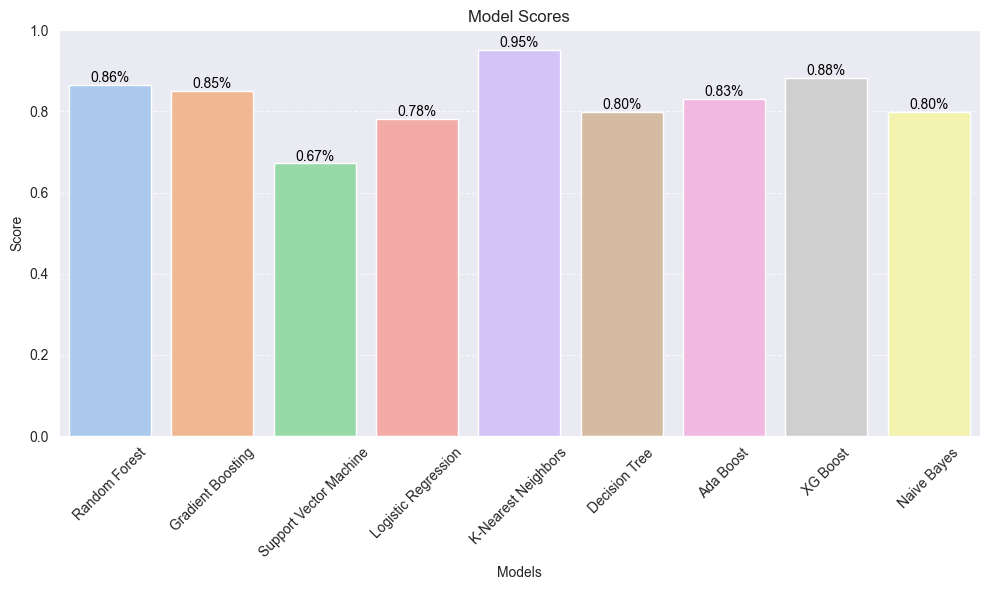

In [116]:
# Define a color palette for the bars
colors = sns.color_palette('pastel', n_colors=len(scores_df))

# Create a bar plot of models and their scores
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Accuracy', data=scores_df, palette=colors)

# Add text on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Model Scores')
plt.xlabel('Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

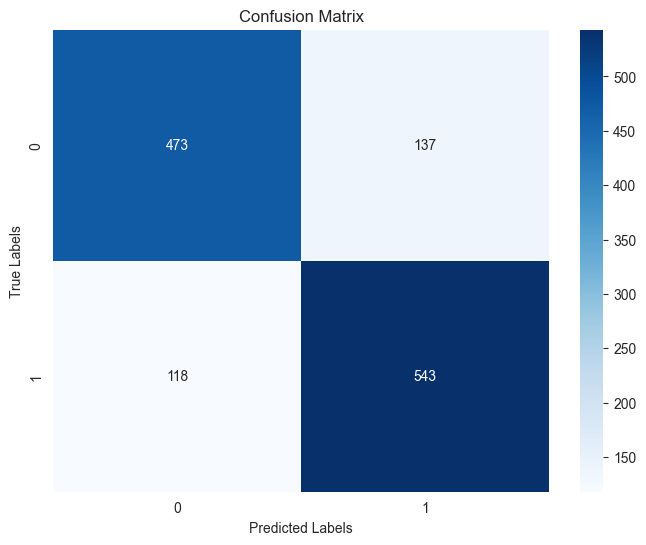

In [117]:
# Compute confusion matrix
conf_matrix = confusion_matrix(yr_test, yr_pred)

# Display confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [118]:
import pickle

# Assuming your best KNN model is stored in the variable best_model
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [119]:
model_version = 1
model_filename = f'knn_model_v{model_version}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

In [120]:
with open('knn_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)